In [ ]:
# # for data in data folder 
# DATA_DIR = Path("/kaggle/input/nfl-big-data-bowl-2026-prediction/")
# OUTPUT_DIR = Path("./outputs")
# train_input_files = [config.DATA_DIR / f"train/input_2023_w{w:02d}.csv" for w in range(1, 19)]
# train_output_files = [config.DATA_DIR / f"train/output_2023_w{w:02d}.csv" for w in range(1, 19)]

In [ ]:
import os
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers

In [ ]:
# Define paths and constants
DATA_PATH = r"C:\Users\Jenna\OneDrive\Documents\NFL-Big-Data-Bowl-2026\data"
TRAIN_PATH = os.path.join(DATA_PATH, "train")
WEEKS = range(1, 19)

# Function to load weekly data
def load_weeks(week_nums):
    inputs = []
    outputs = []
    
    for w in week_nums:
        input_file = os.path.join(TRAIN_PATH, f"input_2023_w{w:02d}.csv")
        output_file = os.path.join(TRAIN_PATH, f"output_2023_w{w:02d}.csv")
        
        inputs.append(pd.read_csv(input_file))
        outputs.append(pd.read_csv(output_file))
    
    input_df = pd.concat(inputs, ignore_index=True)
    output_df = pd.concat(outputs, ignore_index=True)
    
    return {"input_df": input_df, "output_df": output_df}

# Load data
data = load_weeks(WEEKS)
pre_df = data["input_df"]
post_df = data["output_df"]

# num_rows = len(pre_df)
# num_games = pre_df["game_id"].nunique()
print(f"Data loaded: Pre {len(pre_df)} rows, {pre_df["game_id"].nunique()} games\n")
print(f"Data loaded: Pre {len(post_df)} rows, {post_df["game_id"].nunique()} games\n")

Data loaded: Pre 4880579 rows, 272 games

Data loaded: Pre 562936 rows, 272 games



In [ ]:
# # Function to combine pre and post data for all games and plays
# def combine_all_games(pre_df, post_df):
#     # Create game_play column in both dataframes
#     pre_df = pre_df.copy()
#     post_df = post_df.copy()

#     # get rid of plays longer than 60 frames
#     pre_df = pre_df[pre_df['frame_id'] < 101]
#     post_df = post_df[post_df['frame_id'] < 101]
    
#     pre_df['game_play'] = pre_df['game_id'].astype(str) + '_' + pre_df['play_id'].astype(str)
#     post_df['game_play'] = post_df['game_id'].astype(str) + '_' + post_df['play_id'].astype(str)
    
#     # Get max frame_id for each game_play from pre_df
#     game_play_offset_df = pre_df.groupby('game_play')['frame_id'].max().reset_index()
#     game_play_offset_df.columns = ['game_play', 'max_frame_id']
    
#     # Merge offset df onto post_df
#     post_df = post_df.merge(game_play_offset_df, on='game_play', how='left')
    
#     # Calculate continuous frame_id for post_df
#     post_df['frame_id_total'] = post_df['max_frame_id'] + post_df['frame_id']
    
#     # Prepare pre_df for concatenation
#     pre_df['frame_id_total'] = pre_df['frame_id']
#     pre_df['frame'] = 'pre'
#     post_df['frame'] = 'post'
    
#     # Drop temporary columns before concat
#     post_df = post_df.drop(columns=['max_frame_id', 'frame_id'], errors='ignore')
#     pre_df = pre_df.drop(columns=['frame_id'], errors='ignore')
    
#     # Concatenate pre and post together
#     df_combined = pd.concat([pre_df, post_df], ignore_index=True)
    
#     # Sort by game_play, nfl_id, and frame_id_total
#     df_combined = df_combined.sort_values(['game_play', 'nfl_id', 'frame_id_total']).reset_index(drop=True)
    
#     return df_combined

# # Process all games
# df_combined = combine_all_games(pre_df, post_df)

# print(f"{'='*50}")
# print(f"Total combined rows: {len(df_combined)}")
# print(f"Unique games: {df_combined['game_id'].nunique()}")
# print(f"Unique plays: {df_combined['play_id'].nunique()}")
# print(f"Unique players: {df_combined['nfl_id'].nunique()}")
# print(f"\nFrame ID range: {df_combined['frame_id_total'].min()} to {df_combined['frame_id_total'].max()}")
# print(f"Pre rows: {(df_combined['frame'] == 'pre').sum()}")
# print(f"Post rows: {(df_combined['frame'] == 'post').sum()}")

# # Verify continuity for one sample player in one play
# sample_player = df_combined.groupby(['game_play', 'nfl_id']).size().reset_index().iloc[0]
# sample_check = df_combined[
#     (df_combined['game_play'] == sample_player['game_play']) & 
#     (df_combined['nfl_id'] == sample_player['nfl_id'])
# ].sort_values('frame_id_total')

# print(f"\nSample verification (Play: {sample_player['game_play']}, Player: {sample_player['nfl_id']}):")
# print(sample_check[['game_play', 'nfl_id', 'frame_id_total', 'frame']].head())
# print("...")
# print(sample_check[['game_play', 'nfl_id', 'frame_id_total', 'frame']].tail())

Total combined rows: 5440590
Unique games: 272
Unique plays: 4317
Unique players: 1384

Frame ID range: 1 to 106
Pre rows: 4877766
Post rows: 562824

Sample verification (Play: 2023090700_1001, Player: 41325):
         game_play  nfl_id  frame_id_total frame
0  2023090700_1001   41325               1   pre
1  2023090700_1001   41325               2   pre
2  2023090700_1001   41325               3   pre
3  2023090700_1001   41325               4   pre
4  2023090700_1001   41325               5   pre
...
          game_play  nfl_id  frame_id_total frame
33  2023090700_1001   41325              34   pre
34  2023090700_1001   41325              35   pre
35  2023090700_1001   41325              36   pre
36  2023090700_1001   41325              37   pre
37  2023090700_1001   41325              38   pre


In [63]:
# Function to combine pre and post data for all games and plays
def combine_all_games(pre_df, post_df):
    # Create game_play column in both dataframes
    pre_df = pre_df.copy()
    post_df = post_df.copy()

    # get rid of plays longer than 60 frames
    pre_df = pre_df[pre_df['frame_id'] < 101]
    post_df = post_df[post_df['frame_id'] < 101]
    
    pre_df['game_play'] = pre_df['game_id'].astype(str) + '_' + pre_df['play_id'].astype(str)
    post_df['game_play'] = post_df['game_id'].astype(str) + '_' + post_df['play_id'].astype(str)
    
    # Get max frame_id for each game_play from pre_df
    game_play_offset_df = pre_df.groupby('game_play')['frame_id'].max().reset_index()
    game_play_offset_df.columns = ['game_play', 'max_frame_id']
    
    # Merge offset df onto post_df
    post_df = post_df.merge(game_play_offset_df, on='game_play', how='left')
    
    # Calculate continuous frame_id for post_df
    post_df['frame_id_total'] = post_df['max_frame_id'] + post_df['frame_id']
    
    # Prepare pre_df for concatenation
    pre_df['frame_id_total'] = pre_df['frame_id']
    pre_df['frame'] = 'pre'
    post_df['frame'] = 'post'
    
    # Drop temporary columns before concat
    post_df = post_df.drop(columns=['max_frame_id', 'frame_id'], errors='ignore')
    pre_df = pre_df.drop(columns=['frame_id'], errors='ignore')
    
    # Concatenate pre and post together
    df_combined = pd.concat([pre_df, post_df], ignore_index=True)
    
    # Sort by game_play, nfl_id, and frame_id_total
    df_combined = df_combined.sort_values(['game_play', 'nfl_id', 'frame_id_total']).reset_index(drop=True)
    
    return df_combined

# Process all games
df_combined = combine_all_games(pre_df, post_df)

print(f"{'='*50}")
print(f"Total combined rows: {len(df_combined)}")
print(f"Unique games: {df_combined['game_id'].nunique()}")
print(f"Unique plays: {df_combined['game_play'].nunique()}")
print(f"Unique players: {df_combined['nfl_id'].nunique()}")
print(f"\nFrame ID range: {df_combined['frame_id_total'].min()} to {df_combined['frame_id_total'].max()}")
print(f"Pre rows: {(df_combined['frame'] == 'pre').sum()}")
print(f"Post rows: {(df_combined['frame'] == 'post').sum()}")

# Verify continuity for one sample player in one play
sample_player = df_combined.groupby(['game_play', 'nfl_id']).size().reset_index().iloc[0]
sample_check = df_combined[
    (df_combined['game_play'] == sample_player['game_play']) & 
    (df_combined['nfl_id'] == sample_player['nfl_id'])
].sort_values('frame_id_total')

print(f"\nSample verification (Play: {sample_player['game_play']}, Player: {sample_player['nfl_id']}):")
print(sample_check[['game_play', 'nfl_id', 'frame_id_total', 'frame']].head())
print("...")
print(sample_check[['game_play', 'nfl_id', 'frame_id_total', 'frame']].tail())

# --- Sort by game/play/player/frame ---
df_combined.sort_values(
    ["game_id", "play_id", "nfl_id", "frame_id_total"],
    inplace=True,
    kind="mergesort"
)

# --- Forward-fill static player/play info (not motion variables) ---
fill_cols = [
    "player_name", "player_height", "player_weight", "player_birth_date",
    "player_position", "player_side", "player_role", "player_to_predict",
    "absolute_yardline_number", "play_direction", "num_frames_output",
    "ball_land_x", "ball_land_y"
]
fill_cols_existing = [c for c in fill_cols if c in df_combined.columns]

df_combined[fill_cols_existing] = (
    df_combined.groupby(["game_id", "play_id", "nfl_id"])[fill_cols_existing]
               .ffill()
               .bfill()  # ensure first frame also filled
)

print(f"\n{'='*50}")
print("After filling NAs:")
print(f"Remaining NAs per column:\n{df_combined[fill_cols_existing].isna().sum()}")
print(f"\nTotal rows: {len(df_combined)}")

# --- Create x_next and y_next columns ---
df_combined['x_next'] = df_combined.groupby(['game_play', 'nfl_id'])['x'].shift(-1)
df_combined['y_next'] = df_combined.groupby(['game_play', 'nfl_id'])['y'].shift(-1)

print(f"\n{'='*50}")
print("Created x_next and y_next columns")
print(f"x_next NAs: {df_combined['x_next'].isna().sum()}")
print(f"y_next NAs: {df_combined['y_next'].isna().sum()}")
print(f"\nSample data with next positions:")
print(df_combined[['game_play', 'nfl_id', 'frame_id_total', 'x', 'y', 'x_next', 'y_next']].head(10))

df_combined = df_combined.sort_values(["nfl_id", "game_id", "play_id", "frame_id_total"])

dir_rad = np.deg2rad(df_combined["dir"].to_numpy())
df_combined["vx"] = df_combined["s"].to_numpy() * np.cos(dir_rad)
df_combined["vy"] = df_combined["s"].to_numpy() * np.sin(dir_rad)
df_combined["ax"] = df_combined["a"].to_numpy() * np.cos(dir_rad)
df_combined["ay"] = df_combined["a"].to_numpy() * np.sin(dir_rad)
df_combined["dir_rad"] = dir_rad

print(f"\n{'='*50}")
print("Created motion features:")
print(f"vx, vy (velocity components)")
print(f"ax, ay (acceleration components)")
print(f"dir_rad (direction in radians)")
print(f"\nSample motion features:")
print(df_combined[['nfl_id', 'game_play', 'frame_id_total', 's', 'a', 'dir', 'vx', 'vy', 'ax', 'ay']].head(10))

Total combined rows: 5440590
Unique games: 272
Unique plays: 14108
Unique players: 1384

Frame ID range: 1 to 106
Pre rows: 4877766
Post rows: 562824

Sample verification (Play: 2023090700_1001, Player: 41325):
         game_play  nfl_id  frame_id_total frame
0  2023090700_1001   41325               1   pre
1  2023090700_1001   41325               2   pre
2  2023090700_1001   41325               3   pre
3  2023090700_1001   41325               4   pre
4  2023090700_1001   41325               5   pre
...
          game_play  nfl_id  frame_id_total frame
33  2023090700_1001   41325              34   pre
34  2023090700_1001   41325              35   pre
35  2023090700_1001   41325              36   pre
36  2023090700_1001   41325              37   pre
37  2023090700_1001   41325              38   pre


C:\Users\Jenna\AppData\Local\Temp\ipykernel_23728\3367252505.py:84: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .bfill()  # ensure first frame also filled



After filling NAs:
Remaining NAs per column:
player_name                 0
player_height               0
player_weight               0
player_birth_date           0
player_position             0
player_side                 0
player_role                 0
player_to_predict           0
absolute_yardline_number    0
play_direction              0
num_frames_output           0
ball_land_x                 0
ball_land_y                 0
dtype: int64

Total rows: 5440590

Created x_next and y_next columns
x_next NAs: 173150
y_next NAs: 173150

Sample data with next positions:
          game_play  nfl_id  frame_id_total      x      y  x_next  y_next
554  2023090700_101   43290               1  37.36  30.07   37.36   30.07
555  2023090700_101   43290               2  37.36  30.07   37.35   30.07
556  2023090700_101   43290               3  37.35  30.07   37.34   30.07
557  2023090700_101   43290               4  37.34  30.07   37.33   30.07
558  2023090700_101   43290               5  37.33  3

In [33]:
# before 81 frames cut math
print(4880579 - 4877766)
print(562936 - 562824)
print(5443515 - 5440590)

2813
112
2925


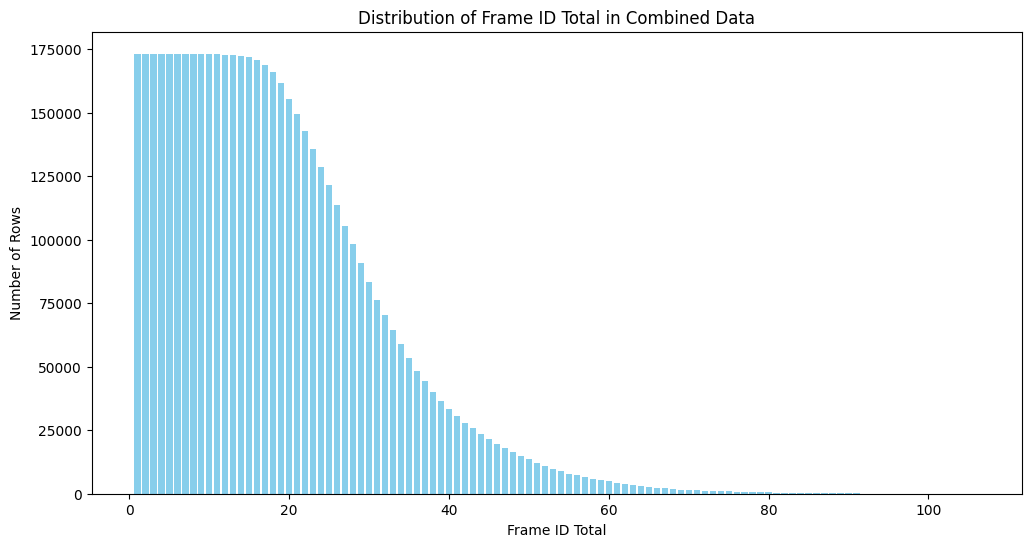

In [ ]:
# plot frame_id_total distribution and how many plays have that frame_id_total
frame_id_counts = df_combined['frame_id_total'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
plt.bar(frame_id_counts.index, frame_id_counts.values, color='skyblue')
plt.xlabel('Frame ID Total')
plt.ylabel('Number of Rows')
plt.title('Distribution of Frame ID Total in Combined Data')
plt.show()

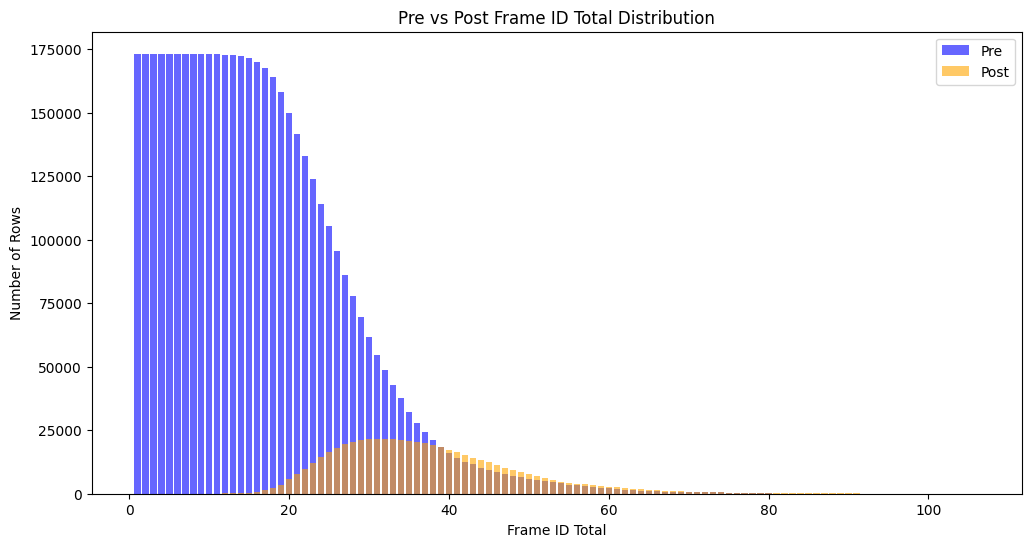

In [41]:
# plot bar plot layered pre frame_id_total vs num_frames_predict
plt.figure(figsize=(12, 6))
pre_df_sample = df_combined[df_combined['frame'] == 'pre']
post_df_sample = df_combined[df_combined['frame'] == 'post']
pre_counts = pre_df_sample['frame_id_total'].value_counts().sort_index()
post_counts = post_df_sample['frame_id_total'].value_counts().sort_index()
plt.bar(pre_counts.index, pre_counts.values, alpha=0.6, label='Pre', color='blue')
plt.bar(post_counts.index, post_counts.values, alpha=0.6, label='Post', color='orange')
plt.xlabel('Frame ID Total')
plt.ylabel('Number of Rows')
plt.title('Pre vs Post Frame ID Total Distribution')
plt.legend()
plt.show()

In [65]:
# show unique player_position and player_role
print(df_combined['player_position'].unique())
print(df_combined['player_role'].unique())

['TE' 'K' 'QB' 'DT' 'DE' 'SS' 'OLB' 'CB' 'WR' 'FS' 'MLB' 'ILB' 'RB' 'FB'
 'NT' 'T' 'S' 'P' 'LB']
['Other Route Runner' 'Targeted Receiver' 'Passer' 'Defensive Coverage']


In [ ]:
# verify df_combined is correct by looking at kader kohou from big df
# Total combined rows for Kader Kohou (Play 55): 51
test = df_combined[
    (df_combined['play_id'] == 55) &
    (df_combined['nfl_id'] == 54936) &
    (df_combined['game_id'] == 2023110500)
]

test
# test['nfl_id'].unique()
# test.columns

# change code below this
    SEED = 42
    N_FOLDS = 5
    BATCH_SIZE = 256
    WINDOW_SIZE = 12
    HIDDEN_DIM = 128
    MAX_FUTURE_HORIZON = 94

    K_NEIGH = 6
    RADIUS = 30.0
    TAU = 8.0
    N_ROUTE_CLUSTERS = 7
    
    FIELD_X_MIN, FIELD_X_MAX = 0.0, 120.0
    FIELD_Y_MIN, FIELD_Y_MAX = 0.0, 53.3

In [ ]:

# --- 11. Convert categoricals ---
cat_cols = ["player_role", "player_position", "play_direction"]
for col in cat_cols:
    df[col] = df[col].astype("category")

# --- 12. Subset to players to predict ---
to_predict = df.loc[df["player_to_predict"]].copy()

# --- 13. Optional: One-hot encoding for model input ---
# Play direction (left/right)
play_dir_categories = to_predict["play_direction"].cat.categories
if "right" in play_dir_categories:
    right_idx = play_dir_categories.get_loc("right")
    to_predict["play_direction_num"] = (
        to_predict["play_direction"].cat.codes == right_idx
    ).astype(int)
# else: could default to 0 if "right" not present

# #Optional numeric encoding for positions/roles (skip if using embeddings)
to_predict["player_position_WR"] = (to_predict["player_position"] == "WR").astype(int)
to_predict["player_position_RB"] = (to_predict["player_position"] == "RB").astype(int)
to_predict["player_position_QB"] = (to_predict["player_position"] == "QB").astype(int)
to_predict["player_role_Targeted"] = (to_predict["player_role"] == "Targeted Receiver").astype(int)
to_predict["player_role_Passer"] = (to_predict["player_role"] == "Passer").astype(int)
to_predict["player_role_Def"] = (to_predict["player_role"] == "Defensive Coverage").astype(int)

to_predict

In [ ]:
# --- Sort by player/play/frame to ensure proper sequences ---
to_predict_game = to_predict.sort_values(
    ["game_id", "play_id", "nfl_id", "frame_id_total"]
)

# --- 14. Feature and target columns ---
feature_cols = [
    "x", "y", "vx", "vy", "ax", "ay",       # motion features
    "o", "dir",                              # orientation
    "play_direction_num",                    # categorical encoded
    "player_position_WR", "player_position_RB", "player_position_QB",  # positions
    "player_role_Targeted", "player_role_Passer", "player_role_Def",  # roles
    "ball_land_x", "ball_land_y"             # ball landing info
    ]

target_cols = ["x_next", "y_next"]

In [ ]:
# --- 20. Define sequence length (all pre-pass frames) ---
# We'll group by player/play and take all frames before the target (x_next, y_next)
group_cols = ["game_id", "play_id", "nfl_id"]

# --- 21. Sort to ensure temporal order ---
to_predict = to_predict.sort_values(group_cols + ["frame_id_total"])

# --- 22. Collect sequences per player/play ---
sequence_features = feature_cols  # all features for the model

player_sequences = []
target_sequences = []

for _, player_df in to_predict.groupby(group_cols):
    # Features: all rows except the last (because last row's target is next frame)
    X_seq = player_df[sequence_features].iloc[:-1].values
    # Targets: x_next, y_next (shifted by -1)
    y_seq = player_df[target_cols].iloc[1:].values

    # Ensure sequence length > 0
    if len(X_seq) > 0:
        player_sequences.append(X_seq)
        target_sequences.append(y_seq)

# --- 23. Pad sequences to same length if needed (for batch training) ---
# Find max sequence length
max_len = max(seq.shape[0] for seq in player_sequences)

# Pad sequences with zeros (or use masking in your model)
X_padded = pad_sequences(player_sequences, maxlen=max_len, dtype='float32', padding='pre', value=0.0)
y_padded = pad_sequences(target_sequences, maxlen=max_len, dtype='float32', padding='pre', value=0.0)

print("Padded X shape:", X_padded.shape)  # (num_players, seq_len, num_features)
print("Padded y shape:", y_padded.shape)  # (num_players, seq_len, 2)


# build pre-snap sequences and masks
def build_pre_target_sequences(df, feature_cols, target_cols, max_pre_len=96):
    X_list, y_list, mask_list = [], [], []

    for (game_id, play_id, nfl_id), grp in df.groupby(["game_id", "play_id", "nfl_id"]):
        pre = grp[grp["frame"] == "pre"].sort_values("frame_id_total")
        if len(pre) == 0:
            continue

        X_seq = pre[feature_cols].values[-max_pre_len:]
        y_seq = pre[target_cols].values[-max_pre_len:]

        X_list.append(X_seq)
        y_list.append(y_seq)
        mask_list.append(np.ones(len(X_seq)))

    X_pad = pad_sequences(X_list, maxlen=max_pre_len, dtype="float32", padding="pre", value=0.0)
    y_pad = pad_sequences(y_list, maxlen=max_pre_len, dtype="float32", padding="pre", value=0.0)
    mask  = pad_sequences(mask_list, maxlen=max_pre_len, dtype="float32", padding="pre", value=0.0)

    return X_pad, y_pad, mask

# SEQ_PRE_LEN = 96
# X_pre, y_tgt, pre_mask = build_pre_target_sequences(to_predict, feature_cols, target_cols, SEQ_PRE_LEN)

# print("X_pre:", X_pre.shape)
# print("y_tgt:", y_tgt.shape)


In [ ]:
# --------------------------------------------------------------
# 1. Build sequences (uses the FIXED function above)
# --------------------------------------------------------------
SEQ_PRE_LEN = 96
X_pre, y_tgt, pre_mask = build_pre_target_sequences(to_predict, feature_cols, target_cols, SEQ_PRE_LEN)

# --------------------------------------------------------------
# 2. Sanity check (should print "All good")
# --------------------------------------------------------------
assert X_pre.shape[0] == y_tgt.shape[0] == pre_mask.shape[0]
print(f"All good → X: {X_pre.shape}, y: {y_tgt.shape}")

# --------------------------------------------------------------
# 3. Scale only real frames
# --------------------------------------------------------------
scaler = StandardScaler()
real_frames = X_pre[pre_mask == 1]
scaled = scaler.fit_transform(real_frames)

X_scaled = X_pre.copy()
X_scaled[pre_mask == 1] = scaled

# --------------------------------------------------------------
# 4. Train/val split (sequence level)
# --------------------------------------------------------------
idx_train, idx_val = train_test_split(np.arange(X_scaled.shape[0]), test_size=0.2, random_state=42)

X_train, X_val = X_scaled[idx_train], X_scaled[idx_val]
y_train, y_val = y_tgt[idx_train],   y_tgt[idx_val]

print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val:   {X_val.shape}, {y_val.shape}")

# --------------------------------------------------------------
# 5. Build model
# --------------------------------------------------------------
def build_model(seq_len, n_feat):
    inputs = layers.Input(shape=(seq_len, n_feat))
    masked = layers.Masking(mask_value=0.0)(inputs)
    lstm   = layers.LSTM(128, return_sequences=True)(masked)
    drop   = layers.Dropout(0.15)(lstm)
    dense  = layers.TimeDistributed(layers.Dense(64, activation="relu"))(drop)
    out    = layers.TimeDistributed(layers.Dense(2, activation="linear"))(dense)

    model = models.Model(inputs, out)
    model.compile(optimizer=optimizers.Adam(1e-3), loss="mse",
                  metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])
    return model

model = build_model(SEQ_PRE_LEN, X_train.shape[2])

# model = build_model(SEQ_PRE_LEN, X_train.shape[2])
model.summary()

In [ ]:
## train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=35,
    batch_size = 64,
    verbose=2
)

In [ ]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Training Performance")
plt.show()

# Numeric evaluation
loss, mse = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation MSE: {mse:.3f} yards")

In [ ]:
train_mse = history.history['loss']
val_mse = history.history['val_loss']
print(min(val_mse))
print(max(val_mse))

## Section 1 Preprocessing
- Categorical conversion → ready for embeddings
- Filtering → only players to predict, excluding NaN targets
- Feature definition → keeps raw categorical columns (no one-hot encoding)
- Sequence building → per player/play, with variable lengths tracked
- Padding → to max length with proper masking
- Scaling → only on real (non-padded) frames
- Train/val split → random plays (80/20)

You'll have X_train, y_train, X_val, y_val, mask_train, mask_val ready for the model.

In [ ]:
# --- 1. Convert categoricals to category type ---
cat_cols = ["player_role", "player_position", "play_direction"]
for col in cat_cols:
    df_combined[col] = df_combined[col].astype("category")

# --- 2. Subset to players to predict ---
to_predict = df_combined[df_combined["player_to_predict"] == True].copy()

print(f"Rows to predict: {len(to_predict)}")
print(f"Unique games: {to_predict['game_id'].nunique()}")
print(f"Unique plays: {to_predict['game_play'].nunique()}")
print(f"Unique players: {to_predict['nfl_id'].nunique()}")

# --- 3. Exclude rows with NaN targets (x_next, y_next) ---
to_predict = to_predict.dropna(subset=['x_next', 'y_next'])

print(f"\nAfter excluding NaN targets: {len(to_predict)} rows")

# --- 4. Define feature columns (skip one-hot encoding, use raw categoricals for embeddings) ---
feature_cols = [
    "x", "y", "vx", "vy", "ax", "ay",       # motion features
    "o", "dir", "dir_rad",                  # orientation
    "ball_land_x", "ball_land_y",           # ball landing info
    "player_position", "player_role",       # categorical (will use embeddings)
    "play_direction"                        # categorical (will use embeddings)
]

target_cols = ["x_next", "y_next"]

# Verify all feature columns exist
feature_cols_existing = [c for c in feature_cols if c in to_predict.columns]
print(f"\nFeature columns ({len(feature_cols_existing)}): {feature_cols_existing}")

# --- 5. Sort by temporal order ---
to_predict = to_predict.sort_values(["game_id", "play_id", "nfl_id", "frame_id_total"]).reset_index(drop=True)

# --- 6. Convert categorical codes (for embedding input) ---
cat_feature_cols = ["player_position", "player_role", "play_direction"]
for col in cat_feature_cols:
    if col in to_predict.columns:
        to_predict[f"{col}_code"] = to_predict[col].cat.codes

# Update feature columns to use categorical codes
feature_cols_numeric = [c if c not in cat_feature_cols else f"{c}_code" for c in feature_cols_existing]

print(f"\nCategorical codes created")
print(f"Updated feature columns: {feature_cols_numeric}")

# --- 7. Build sequences per player/play ---
group_cols = ["game_id", "play_id", "nfl_id"]
player_sequences = []
target_sequences = []
game_play_nfl_info = []  # Store group info for later

for (game_id, play_id, nfl_id), grp in to_predict.groupby(group_cols):
    # Features: all rows (will use x_next/y_next as targets, not as features)
    X_seq = grp[feature_cols_numeric].values.astype('float32')
    y_seq = grp[target_cols].values.astype('float32')
    
    # Ensure sequence length > 0
    if len(X_seq) > 0:
        player_sequences.append(X_seq)
        target_sequences.append(y_seq)
        game_play_nfl_info.append((game_id, play_id, nfl_id, len(X_seq)))

print(f"\nTotal sequences: {len(player_sequences)}")
print(f"Sequence lengths: min={min(s.shape[0] for s in player_sequences)}, max={max(s.shape[0] for s in player_sequences)}")

# --- 8. Pad sequences to max length ---
max_len = max(seq.shape[0] for seq in player_sequences)
num_features = len(feature_cols_numeric)

print(f"\nMax sequence length: {max_len}")
print(f"Number of features: {num_features}")

X_padded = pad_sequences(
    player_sequences, 
    maxlen=max_len, 
    dtype='float32', 
    padding='pre', 
    value=0.0
)
y_padded = pad_sequences(
    target_sequences, 
    maxlen=max_len, 
    dtype='float32', 
    padding='pre', 
    value=0.0
)

print(f"\nPadded X shape: {X_padded.shape}")  # (num_sequences, max_len, num_features)
print(f"Padded y shape: {y_padded.shape}")  # (num_sequences, max_len, 2)

# --- 9. Create mask for real frames (non-padded) ---
mask = np.zeros((len(player_sequences), max_len), dtype='float32')
for i, (_, _, _, seq_len) in enumerate(game_play_nfl_info):
    mask[i, max_len - seq_len:] = 1.0  # Mark real frames

print(f"Mask shape: {mask.shape}")
print(f"Sample mask (first sequence): {mask[0]}")

# --- 10. Scale features (only on real frames, skip categorical codes) ---
# Get indices of numeric features (exclude categorical codes for scaling)
numeric_indices = [i for i, col in enumerate(feature_cols_numeric) if not col.endswith('_code')]

scaler = StandardScaler()
real_frames_numeric = X_padded[mask == 1][:, numeric_indices]
scaled = scaler.fit_transform(real_frames_numeric)

X_scaled = X_padded.copy()
X_scaled[mask == 1][:, numeric_indices] = scaled

print(f"\nFeature scaling complete (numeric features only)")
print(f"X_scaled mean: {X_scaled[mask == 1][:, numeric_indices].mean():.3f}, std: {X_scaled[mask == 1][:, numeric_indices].std():.3f}")

# --- 11. Train/val split (random plays across all weeks) ---
idx_train, idx_val = train_test_split(
    np.arange(X_scaled.shape[0]), 
    test_size=0.2, 
    random_state=42
)

X_train, X_val = X_scaled[idx_train], X_scaled[idx_val]
y_train, y_val = y_padded[idx_train], y_padded[idx_val]
mask_train, mask_val = mask[idx_train], mask[idx_val]

print(f"\nTrain: X={X_train.shape}, y={y_train.shape}, mask={mask_train.shape}")
print(f"Val:   X={X_val.shape}, y={y_val.shape}, mask={mask_val.shape}")

# Store info for model building
SEQ_LEN = max_len
NUM_FEATURES = num_features
NUMERIC_FEATURE_INDICES = numeric_indices
CATEGORICAL_FEATURE_INDICES = [i for i, col in enumerate(feature_cols_numeric) if col.endswith('_code')]

print(f"\nReady for model building:")
print(f"SEQ_LEN={SEQ_LEN}, NUM_FEATURES={NUM_FEATURES}")
print(f"Numeric features: {len(NUMERIC_FEATURE_INDICES)}, Categorical: {len(CATEGORICAL_FEATURE_INDICES)}")
print(f"Feature columns: {feature_cols_numeric}")

Rows to predict: 1865626
Unique games: 272
Unique plays: 14108
Unique players: 1178

After excluding NaN targets: 1819581 rows

Feature columns (14): ['x', 'y', 'vx', 'vy', 'ax', 'ay', 'o', 'dir', 'dir_rad', 'ball_land_x', 'ball_land_y', 'player_position', 'player_role', 'play_direction']

Categorical codes created
Updated feature columns: ['x', 'y', 'vx', 'vy', 'ax', 'ay', 'o', 'dir', 'dir_rad', 'ball_land_x', 'ball_land_y', 'player_position_code', 'player_role_code', 'play_direction_code']

Total sequences: 46045
Sequence lengths: min=14, max=105

Max sequence length: 105
Number of features: 14

Padded X shape: (46045, 105, 14)
Padded y shape: (46045, 105, 2)
Mask shape: (46045, 105)
Sample mask (first sequence): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

## Section 2: Model Building with Embeddings & LSTM?
Key features:

- Embedding layers for player_position, player_role, play_direction (each gets learned embeddings)
- Separate inputs for numeric and categorical features
- Masking applied to numeric features (handles padding)
- Two stacked LSTM layers (128 → 64 units) with dropout
- TimeDistributed Dense layers for frame-by-frame predictions
- Output: x, y predictions for each frame in the sequence

Architecture flow:

- Input (batch, 105 frames, 14 features)
- Numeric features (11) → masked
- Categorical codes (3) → embedded (3 × 16 = 48 dims) → reshaped
- Concatenated (11 + 48 = 59 dims) → LSTM → Dense → Output (2 dims)

In [71]:
# --- 1. Get embedding vocabulary sizes ---
# Determine unique values for each categorical feature
player_position_vocab = to_predict['player_position'].cat.categories.size
player_role_vocab = to_predict['player_role'].cat.categories.size
play_direction_vocab = to_predict['play_direction'].cat.categories.size

print(f"Embedding vocabulary sizes:")
print(f"  player_position: {player_position_vocab}")
print(f"  player_role: {player_role_vocab}")
print(f"  play_direction: {play_direction_vocab}")

# --- 2. Build model with embeddings ---
def build_model_with_embeddings(
    seq_len, 
    num_numeric_features,
    player_position_vocab_size,
    player_role_vocab_size,
    play_direction_vocab_size,
    embedding_dim=16,
    lstm_units=128,
    dense_units=64
):
    """
    Model architecture:
    - Input: (seq_len, num_features) where last 3 features are categorical codes
    - Separate numeric and categorical inputs
    - Create embeddings for categorical features
    - Concatenate embeddings with numeric features
    - LSTM with masking
    - TimeDistributed Dense layers
    - Output: (seq_len, 2) for x, y predictions
    """
    
    # Input layer
    inputs = layers.Input(shape=(seq_len, num_numeric_features + 3))
    
    # --- Separate numeric and categorical features ---
    numeric_input = layers.Lambda(lambda x: x[..., :num_numeric_features])(inputs)
    cat_input = layers.Lambda(lambda x: x[..., num_numeric_features:])(inputs)
    
    # --- Apply masking to numeric features ---
    masked = layers.Masking(mask_value=0.0)(numeric_input)
    
    # --- Extract individual categorical features ---
    player_position_input = layers.Lambda(lambda x: x[..., 0:1])(cat_input)  # (batch, seq_len, 1)
    player_role_input = layers.Lambda(lambda x: x[..., 1:2])(cat_input)      # (batch, seq_len, 1)
    play_direction_input = layers.Lambda(lambda x: x[..., 2:3])(cat_input)   # (batch, seq_len, 1)
    
    # --- Create embeddings ---
    player_position_emb = layers.Embedding(
        input_dim=player_position_vocab_size,
        output_dim=embedding_dim,
        name="player_position_embedding"
    )(player_position_input)
    player_position_emb = layers.Reshape((seq_len, embedding_dim))(player_position_emb)
    
    player_role_emb = layers.Embedding(
        input_dim=player_role_vocab_size,
        output_dim=embedding_dim,
        name="player_role_embedding"
    )(player_role_input)
    player_role_emb = layers.Reshape((seq_len, embedding_dim))(player_role_emb)
    
    play_direction_emb = layers.Embedding(
        input_dim=play_direction_vocab_size,
        output_dim=embedding_dim,
        name="play_direction_embedding"
    )(play_direction_input)
    play_direction_emb = layers.Reshape((seq_len, embedding_dim))(play_direction_emb)
    
    # --- Concatenate numeric features with embeddings ---
    combined = layers.Concatenate()(
        [masked, player_position_emb, player_role_emb, play_direction_emb]
    )
    
    # --- LSTM layers ---
    lstm1 = layers.LSTM(lstm_units, return_sequences=True, dropout=0.15)(combined)
    lstm2 = layers.LSTM(lstm_units // 2, return_sequences=True, dropout=0.15)(lstm1)
    
    # --- TimeDistributed Dense layers ---
    dense = layers.TimeDistributed(
        layers.Dense(dense_units, activation="relu")
    )(lstm2)
    drop = layers.Dropout(0.15)(dense)
    
    # --- Output layer (predict x, y for each frame) ---
    outputs = layers.TimeDistributed(
        layers.Dense(2, activation="linear", name="xy_output")
    )(drop)
    
    # Create model
    model = models.Model(inputs, outputs)
    
    # Compile
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss="mse",
        metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")]
    )
    
    return model

# --- 3. Build the model ---
model = build_model_with_embeddings(
    seq_len=SEQ_LEN,
    num_numeric_features=len(NUMERIC_FEATURE_INDICES),
    player_position_vocab_size=player_position_vocab,
    player_role_vocab_size=player_role_vocab,
    play_direction_vocab_size=play_direction_vocab,
    embedding_dim=16,
    lstm_units=128,
    dense_units=64
)

print("\n" + "="*60)
print("Model Architecture:")
print("="*60)
model.summary()

# --- 4. Train the model ---
print("\n" + "="*60)
print("Training...")
print("="*60)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=35,
    batch_size=64,
    verbose=2
)

# --- 5. Plot training history ---
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Training Performance")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history["rmse"], label="Train RMSE")
plt.plot(history.history["val_rmse"], label="Val RMSE")
plt.xlabel("Epoch")
plt.ylabel("RMSE (yards)")
plt.legend()
plt.title("RMSE Performance")
plt.grid(True)

plt.tight_layout()
plt.show()

# --- 6. Evaluate on validation set ---
print("\n" + "="*60)
print("Validation Evaluation:")
print("="*60)

val_loss, val_rmse = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation MSE Loss: {val_loss:.6f}")
print(f"Validation RMSE: {val_rmse:.6f} yards")

train_loss = min(history.history['loss'])
val_loss_min = min(history.history['val_loss'])
print(f"\nBest Train Loss: {train_loss:.6f}")
print(f"Best Val Loss: {val_loss_min:.6f}")

# --- 7. Sample prediction check ---
print("\n" + "="*60)
print("Sample Predictions (first sequence):")
print("="*60)

sample_pred = model.predict(X_val[:1], verbose=0)
print(f"Sample input shape: {X_val[:1].shape}")
print(f"Sample prediction shape: {sample_pred.shape}")
print(f"Sample predictions (first 5 frames):\n{sample_pred[0, :5, :]}")
print(f"Actual targets (first 5 frames):\n{y_val[0, :5, :]}")

Embedding vocabulary sizes:
  player_position: 19
  player_role: 4
  play_direction: 2

Model Architecture:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 105, 14)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 105, 11)   │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_6 (Lambda)   │ (None, 105, 3)    │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_7 (Lambda)   │ (None, 105, 1)    │          0 │ lambda_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_8 (Lambda)   │ (None, 105, 1)    │          0 │ lambda_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_9 (Lambda)   │ (None, 105, 1)    │          0 │ lambda_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 105, 11)   │          0 │ lambda_5[0][0]    │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_1 (Masking) │ (None, 105, 11)   │          0 │ lambda_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ player_position_em… │ (None, 105, 1,    │        304 │ lambda_7[0][0]    │
│ (Embedding)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ player_role_embedd… │ (None, 105, 1,    │         64 │ lambda_8[0][0]    │
│ (Embedding)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ play_direction_emb… │ (None, 105, 1,    │         32 │ lambda_9[0][0]    │
│ (Embedding)         │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_2 (Any)         │ (None, 105)       │          0 │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 105, 16)   │          0 │ player_position_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 105, 16)   │          0 │ player_role_embe… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 105, 16)   │          0 │ play_direction_e… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expand_dims_1       │ (None, 105, 1)    │          0 │ any_2[0][0]       │
│ (ExpandDims)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zeros_like_1        │ (None, 105, 11)   │          0 │ masking_1[0][0]   │
│ (ZerosLike)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logical_or_1        │ (None, 105, 11)   │          0 │ expand_dims_1[0]… │
│ (LogicalOr)         │                   │            │ zeros_like_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ones_like_3         │ (None, 105, 16)   │          0 │ reshape_3[0][0]   │
│ (OnesLike)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ones_like_4         │ (None, 105, 16)   │          0 │ reshape_4[0][0]   │
│ (OnesLike)          │                   │            │                 

 Total params: 150,354 (587.32 KB)

 Trainable params: 150,354 (587.32 KB)

 Non-trainable params: 0 (0.00 B)


Training...
Epoch 1/35
576/576 - 248s - 431ms/step - loss: 946.8655 - rmse: 30.7712 - val_loss: 931.3972 - val_rmse: 30.5188
Epoch 2/35
576/576 - 242s - 421ms/step - loss: 928.9492 - rmse: 30.4787 - val_loss: 913.9500 - val_rmse: 30.2316
Epoch 3/35


KeyboardInterrupt: 

## Section 3: Inference & API Wrapper broken down:
prepare_play_for_inference() — Prepares a single play's pre-frames:

- Filters to one player at a time
- Converts categoricals to codes (matching training)
- Scales numeric features with the training scaler
- Pads to SEQ_LEN
- Returns dict of sequences ready for model input

predict_player_trajectory() — Autoregressive prediction (the core logic):

- Takes SEQ_LEN pre-frames as input
- Model predicts next frame's (x, y)
- Shifts sequence left and appends predicted (x, y) as new frame
- Uses updated sequence to predict next frame
- Repeats num_frames_to_predict times
- Returns array of all predicted (x, y) positions

predict() — Main API function:

- Called once per play by Kaggle API
- Takes test (rows to predict) and test_input (pre-frames)
- Runs prepare_play_for_inference() for each player
- Runs predict_player_trajectory() for each player
- Builds output DataFrame matching the order of test
- Returns predictions

API Server — Wraps everything for Kaggle:

- Creates inference server
- Handles batch streaming (plays come one at a time)
- Manages 5-minute response deadlines 

In [ ]:
# SECTION 3: INFERENCE & API WRAPPER
# This section handles:
# 1. Preparing test data (pre-pass frames) for inference
# 2. Autoregressive prediction (predict frame-by-frame, feed predictions back)
# 3. API wrapper function for Kaggle submission

# --- 1. Helper function: Prepare a single play's pre-frames for inference ---
def prepare_play_for_inference(test_input_df, player_rows, feature_cols_numeric, scaler):
    """
    Converts a single play's pre-pass tracking data into model input format.
    
    Args:
        test_input_df: DataFrame with pre-pass frames for one play
        player_rows: List of (nfl_id, num_frames_output) tuples to predict
        feature_cols_numeric: List of feature column names (with categorical codes)
        scaler: StandardScaler fitted on training data
    
    Returns:
        sequences_dict: {(nfl_id, num_frames_to_predict): scaled_feature_array}
    """
    sequences_dict = {}
    
    for nfl_id, num_frames_output in player_rows:
        # Filter to just this player's pre-frames
        player_pre = test_input_df[test_input_df['nfl_id'] == nfl_id].copy()
        
        if len(player_pre) == 0:
            continue
        
        # Convert categorical columns to codes (same as training)
        player_pre['player_position_code'] = player_pre['player_position'].cat.codes
        player_pre['player_role_code'] = player_pre['player_role'].cat.codes
        player_pre['play_direction_code'] = player_pre['play_direction'].cat.codes
        
        # Extract features in same order as training
        X_seq = player_pre[feature_cols_numeric].values.astype('float32')
        
        # Scale numeric features only (indices 0-10, skip categorical codes)
        numeric_indices = [i for i, col in enumerate(feature_cols_numeric) if not col.endswith('_code')]
        X_seq[:, numeric_indices] = scaler.transform(X_seq[:, numeric_indices])
        
        # Pad to SEQ_LEN (same as training)
        X_padded = np.zeros((SEQ_LEN, X_seq.shape[1]), dtype='float32')
        X_padded[-len(X_seq):] = X_seq  # Pad at beginning (pre-padding)
        
        sequences_dict[(nfl_id, num_frames_output)] = X_padded
    
    return sequences_dict


# --- 2. Autoregressive prediction function ---
def predict_player_trajectory(model, X_pre, num_frames_to_predict, feature_cols_numeric, 
                              scaler, numeric_indices):
    """
    Autoregressively predicts player trajectory frame-by-frame.
    
    How it works:
    - Start with pre-pass frames (input)
    - Predict next frame's (x, y)
    - Append predicted (x, y) to sequence as new features
    - Use updated sequence to predict next frame
    - Repeat num_frames_to_predict times
    
    Args:
        model: Trained LSTM model
        X_pre: Padded pre-frames array (SEQ_LEN, num_features)
        num_frames_to_predict: How many post-pass frames to predict
        feature_cols_numeric: Feature column names
        scaler: Fitted scaler from training
        numeric_indices: Indices of numeric features (not categorical codes)
    
    Returns:
        predictions: Array of shape (num_frames_to_predict, 2) with x, y for each frame
    """
    predictions = []
    
    # Start with pre-frames as context
    X_current = X_pre.copy()
    
    for frame_num in range(num_frames_to_predict):
        # Predict next frame: shape (1, SEQ_LEN, num_features) -> (1, SEQ_LEN, 2)
        y_pred = model.predict(X_current[np.newaxis, :, :], verbose=0)
        
        # Get the last frame's prediction (x_next, y_next)
        # Note: y_pred shape is (1, SEQ_LEN, 2), we want the last timestep
        x_pred, y_pred_val = y_pred[0, -1, :]
        
        # Store prediction
        predictions.append([x_pred, y_pred_val])
        
        # --- Prepare next input sequence by shifting and appending new features ---
        # Shift sequence left (remove first frame, make room for new frame)
        X_current = np.roll(X_current, -1, axis=0)
        
        # For the new last frame, we need to construct features
        # We'll use the predicted (x, y) and keep categorical/static info from last real frame
        last_frame = X_current[-2, :].copy()  # Get what's now second-to-last
        
        # Update position (x, y are first 2 features)
        last_frame[0] = x_pred
        last_frame[1] = y_pred_val
        
        # Keep other features (vx, vy, ax, ay, o, dir, etc.) from previous frame
        # In a real scenario, you might estimate velocity from consecutive predictions
        # For now, we'll smooth or keep the previous values
        
        X_current[-1, :] = last_frame
    
    return np.array(predictions)


# --- 3. Main predict function for API ---
def predict(test: pl.DataFrame, test_input: pl.DataFrame) -> pl.DataFrame:
    """
    Main inference function called by Kaggle API.
    
    This gets called repeatedly for each play in the hidden test set.
    
    Args:
        test: Polars DataFrame with columns [game_id, play_id, nfl_id, frame_id]
              These are the rows we need to predict x, y for
        test_input: Polars DataFrame with pre-pass tracking data for this play
                   Contains: game_id, play_id, nfl_id, frame_id, x, y, vx, vy, ax, ay, 
                            o, dir, ball_land_x, ball_land_y, player_position, etc.
    
    Returns:
        Polars DataFrame with columns [x, y] in same order as test
    """
    
    # Convert Polars to Pandas (easier to work with)
    test_df = test.to_pandas()
    test_input_df = test_input.to_pandas()
    
    # Convert categorical columns to category type (same as training)
    cat_cols = ["player_position", "player_role", "play_direction"]
    for col in cat_cols:
        if col in test_input_df.columns:
            test_input_df[col] = test_input_df[col].astype("category")
    
    # Get unique players and their num_frames_output
    test_input_df = test_input_df.sort_values("frame_id")
    unique_players = test_input_df[["nfl_id", "num_frames_output"]].drop_duplicates()
    player_list = [(row['nfl_id'], row['num_frames_output']) 
                   for _, row in unique_players.iterrows()]
    
    # Prepare sequences for all players in this play
    sequences = prepare_play_for_inference(
        test_input_df, 
        player_list, 
        feature_cols_numeric, 
        scaler
    )
    
    # Predict trajectories
    predictions_dict = {}
    for (nfl_id, num_frames_output), X_seq in sequences.items():
        trajectory = predict_player_trajectory(
            model, 
            X_seq, 
            num_frames_output,
            feature_cols_numeric,
            scaler,
            NUMERIC_FEATURE_INDICES
        )
        predictions_dict[(nfl_id, num_frames_output)] = trajectory
    
    # Build output DataFrame in same order as test
    output_rows = []
    for _, row in test_df.iterrows():
        nfl_id = row['nfl_id']
        
        # Find which player sequence this belongs to
        frame_id = row['frame_id']
        
        # Get the prediction for this nfl_id and frame
        # Need to find the (nfl_id, num_frames) key and extract frame_id-1 (0-indexed)
        for (pid, nframes), traj in predictions_dict.items():
            if pid == nfl_id:
                if frame_id <= len(traj):
                    x_pred, y_pred = traj[frame_id - 1]
                    output_rows.append({'x': x_pred, 'y': y_pred})
                else:
                    # Shouldn't happen if data is clean
                    output_rows.append({'x': 0.0, 'y': 0.0})
                break
    
    # Convert back to Polars
    output_df = pl.DataFrame(output_rows)
    
    return output_df


# --- 4. API Server Setup ---
import kaggle_evaluation.nfl_inference_server

# Create the inference server with our predict function
inference_server = kaggle_evaluation.nfl_inference_server.NFLInferenceServer(predict)

# When running on hidden test set, serve via API
if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    # For local testing, use the gateway
    inference_server.run_local_gateway(
        ('/kaggle/input/nfl-big-data-bowl-2026-prediction/',)
    )